# Logistic Regression with UCI Dataset

In [1]:

import os
os.environ["PYTHONWARNINGS"] = "ignore"

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

import numpy as np
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression


from IF import first_order, adaptive_first_order
from Borda_count import Borda_count

from sklearn.preprocessing import LabelEncoder
from ucimlrepo import fetch_ucirepo

In [2]:
ks = list(range(1, 101, 3)) + [100]
methods = ["ZAMinfluence", "Adaptive ZAMinfluence"]
UCI_id = 107
class_combo = [(0, 1)]
test_size = 50
num_methods, num_experiments, num_ks = len(methods), test_size, len(ks)

In [3]:
UCI_dataset = fetch_ucirepo(id=UCI_id)

X = np.array(UCI_dataset.data.features)
Y = np.array(LabelEncoder().fit_transform(UCI_dataset.data.targets))

# Print the shape of features and labels
print("Shape of features:", X.shape)
print("Shape of labels:", Y.shape)

# Find unique labels
unique_labels = np.unique(Y)
print("Unique labels:", unique_labels)

X = X[np.isin(Y, class_combo).flatten()]
Y = Y[np.isin(Y, class_combo).flatten()]

n_train = len(Y) - test_size

# Create an array of indices
indices = np.arange(len(Y))
np.random.shuffle(indices)

# Use the shuffled indices to randomly select data for training and testing
X_train, Y_train = X[indices[:n_train]], Y[indices[:n_train]]
X_test, Y_test = X[indices[n_train:]], Y[indices[n_train:]]

# Print the shape of features and labels
print("Shape of features:", X_train.shape)

Shape of features: (5000, 21)
Shape of labels: (5000,)
Unique labels: [0 1 2]
Shape of features: (3254, 21)


In [4]:
def actual_effect(X_train, y_train, x_test, y_test, subset_to_remove, original_value):
    reduced_X_train = np.delete(X_train, subset_to_remove, axis=0)
    reduced_Y_train = np.delete(y_train, subset_to_remove, axis=0)

    lr = LogisticRegression(penalty=None).fit(reduced_X_train, reduced_Y_train)
    logp = lr.predict_log_proba(x_test.reshape(1, -1))[0]
    reduced_value = logp[y_test] - logp[1 - y_test]
    # reduced_value = lr.predict_proba(x_test.reshape(1, -1))[0][1]

    return reduced_value - original_value

In [5]:
def score(i_th_test, k):
    x_test, y_test = X_test[i_th_test], Y_test[i_th_test]
    lr = LogisticRegression(penalty=None).fit(X_train, Y_train)
    logp = lr.predict_log_proba(x_test.reshape(1, -1))[0]
    original_value = logp[y_test] - logp[1 - y_test]
    # original_value = lr.predict_proba(x_test.reshape(1, -1))[0][1]

    scores = np.array([
        actual_effect(X_train, Y_train, x_test, y_test, first_order(X_train, Y_train, x_test, y_test)[:k], original_value),
        actual_effect(X_train, Y_train, x_test, y_test, adaptive_first_order(X_train, Y_train, x_test, y_test, k=k), original_value)
    ])

    return scores

In [6]:
scores_array = np.array(Parallel(n_jobs=50)(delayed(score)(i, k) for i in range(num_experiments) for k in ks))
scores_array = scores_array.reshape((num_experiments, num_ks, -1))

scores_method_ks_combo = scores_array.swapaxes(0, 2) # method, k, combo
scores_ks_method_combo = scores_method_ks_combo.swapaxes(0, 1) # k, method, combo

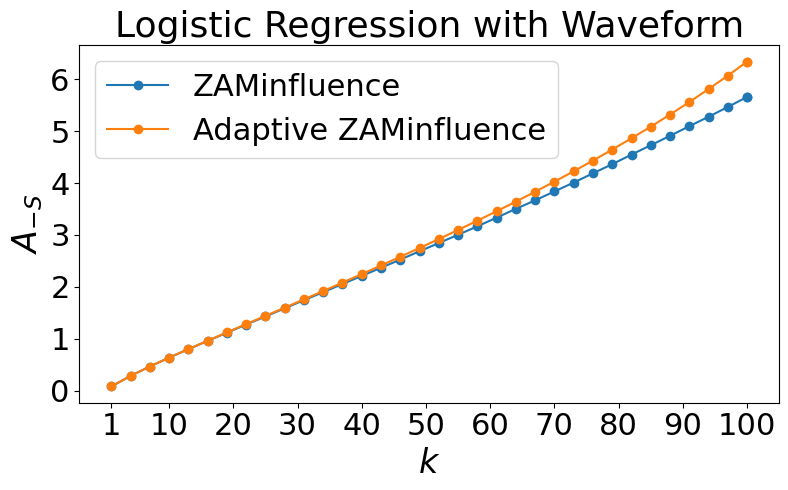

In [7]:
scores_ks_method = scores_ks_method_combo.mean(axis=2)

plt.figure(figsize=(8, 5))  # Create a single plot

plt.title(f'Logistic Regression with Waveform', fontsize=26)

# plt.xlabel('k', fontsize=24)
# plt.ylabel('Actual Effect', fontsize=24)

plt.xlabel('$k$', fontsize=24)
plt.ylabel('$A_{-S}$', fontsize=24)

for method_idx, method_name in enumerate(methods):
     plt.plot(ks, scores_ks_method[:, method_idx], marker='o', label=method_name)

plt.xticks(np.insert(np.arange(10, max(ks)+1, 10), 0, 1), fontsize=22)
plt.yticks(fontsize=22)

plt.legend(methods, fontsize=22)

plt.tight_layout()

plt.savefig('../Figures/Logistic_Regression_uci.svg', format='svg', dpi=300)

plt.show()

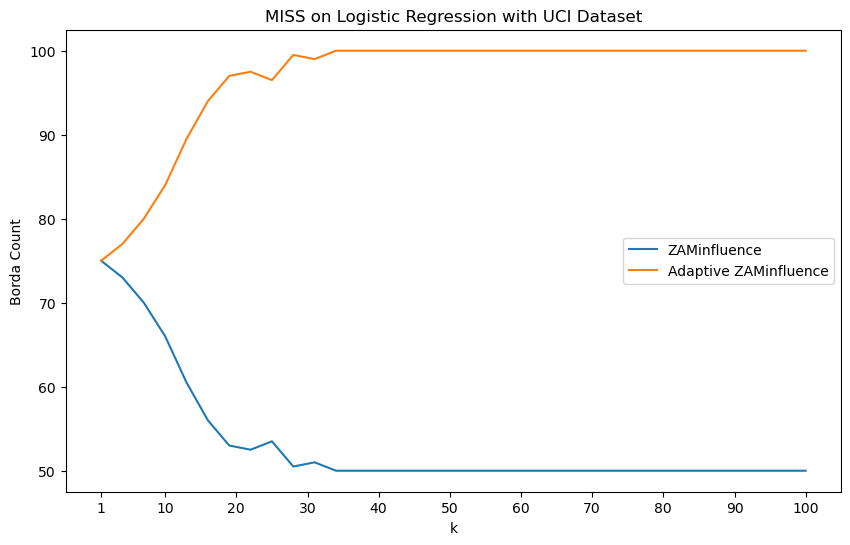

In [8]:
Borda_result = np.array(Parallel(n_jobs=50)(delayed(Borda_count)(scores_ks_method_combo[k_idx]) for k_idx in range(num_ks)))

plt.figure(figsize=(10, 6))

plt.title(f'MISS on Logistic Regression with UCI Dataset')

plt.xlabel('k')
plt.ylabel('Borda Count')

# Plot each method's Borda Count against k
for method_idx, method_name in enumerate(methods):
    plt.plot(ks, Borda_result[:, method_idx], label=method_name)

plt.xticks(np.insert(np.arange(10, max(ks)+1, 10), 0, 1))
plt.legend(methods)
plt.show()